In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [ ]:
from google.colab import files
from IPython.display import Image

In [2]:
uploaded=files.upload();

NameError: name 'files' is not defined

In [3]:
uploaded=files.upload();

NameError: name 'files' is not defined

In [4]:
def load_image(img_path):
  img=tf.io.read_file(img_path)
  img=tf.image.decode_image(img,channels=3)
  img=tf.image.convert_image_dtype(img,tf.float32)
  img=img[tf.newaxis, :]
  return img


In [5]:
content_image = load_image('./static/uploads/test1.jpg')
style_image = load_image('./data/cubism/train/0aou4tal.jpg')

In [6]:
content_image.shape

TensorShape([1, 354, 536, 3])

In [7]:
style_image.shape

TensorShape([1, 256, 256, 3])

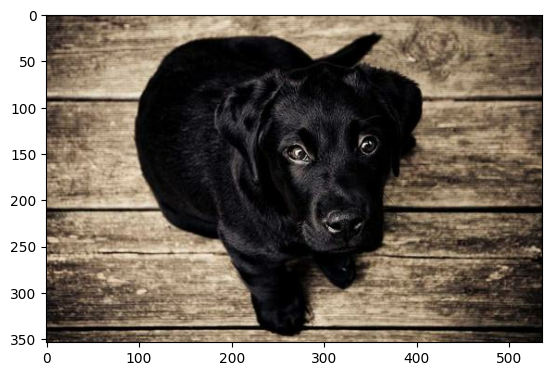

In [8]:
#visualize image
import numpy as np
plt.imshow(np.squeeze(content_image))
plt.show()

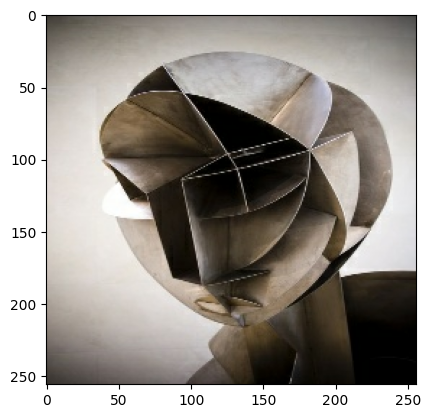

In [9]:
plt.imshow(np.squeeze(style_image))
plt.show()

In [10]:
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
width, height = keras.preprocessing.image.load_img('./static/uploads/test1.jpg').size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [11]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [12]:
def gram_matrix(x):
	# The gram matrix of an image tensor (feature-wise outer product)
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [13]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [17]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image('./static/uploads/test1.jpg')
style_reference_image = preprocess_image('./data/cubism/train/0aou4tal.jpg')
combination_image = tf.Variable(preprocess_image('./static/uploads/test1.jpg'))
iterations = 1000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=1591.36
Iteration 200: loss=1171.49
Iteration 300: loss=984.92
Iteration 400: loss=878.51
Iteration 500: loss=809.47
Iteration 600: loss=761.19


KeyboardInterrupt: 

In [ ]:
plt.imshow(np.squeeze(combination_image))
plt.show()

NameError: ignored